In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
BASE = Path("/content/drive/MyDrive/biolip_gnn")
FIX_DIR = BASE / "graphs_labeled_v5_fixed837"   # fixed-label graphs
OUT_DIR = BASE / "out"
OUT_DIR.mkdir(exist_ok=True)

npz_files = sorted(FIX_DIR.glob("*.npz"))
print("Fixed graphs found:", len(npz_files))
print("Example:", npz_files[0].name if npz_files else "NONE")

Mounted at /content/drive
Fixed graphs found: 837
Example: 1AEI_A_000434.npz


=== POS-RATE DESCRIBE ===


,n_nodes,positives,pos_rate
count,837.000000,837.000000,837.000000
mean,275.608124,8.540024,0.035681
std,106.099515,7.151798,0.037855
min,5.000000,0.000000,0.000000
25%,198.000000,4.000000,0.014925
50%,267.000000,7.000000,0.026316
75%,361.000000,11.000000,0.043590
max,500.000000,90.000000,0.465517


% graphs with 0 positives: 0.24%

Label modes:
label_mode
field7_fixed    836
empty_field7      1
Name: count, dtype: int64


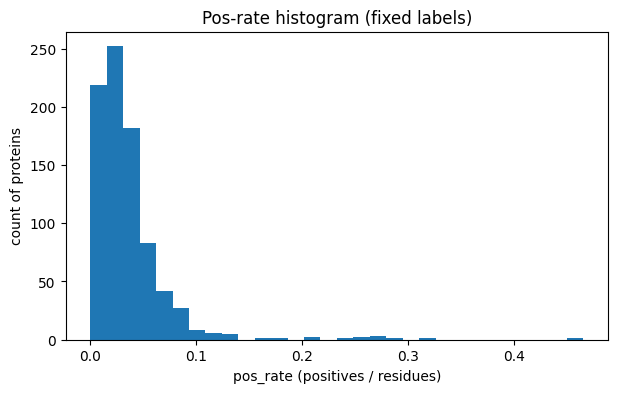

In [5]:
import numpy as np
import pandas as pd

rows = []
for p in npz_files:
    z = np.load(p, allow_pickle=True)
    y = z["y"].astype(int)
    n = len(y)
    pos = int(y.sum())
    rows.append({
        "graph": p.stem,
        "n_nodes": n,
        "positives": pos,
        "pos_rate": pos / max(n, 1),
        "label_mode": str(z["label_mode"]) if "label_mode" in z.files else "NA",
    })

stats = pd.DataFrame(rows)

print("=== POS-RATE DESCRIBE ===")
display(stats[["n_nodes","positives","pos_rate"]].describe())

zero_pct = (stats["positives"] == 0).mean() * 100
print(f"% graphs with 0 positives: {zero_pct:.2f}%")

print("\nLabel modes:")
print(stats["label_mode"].value_counts().head(10))

# Histogram (simple)
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.hist(stats["pos_rate"], bins=30)
plt.title("Pos-rate histogram (fixed labels)")
plt.xlabel("pos_rate (positives / residues)")
plt.ylabel("count of proteins")
plt.show()



In [7]:
!pip -q install torch_geometric scikit-learn

import torch
from torch_geometric.data import Data
from torch_geometric.utils import degree

def load_npz(path: Path) -> dict:
  z = np.load(path, allow_pickle = True)
  return {k: z[k] for k in z.files}

raw_graphs = [load_npz(p) for p in npz_files]

def compute_degree(edge_index: torch.Tensor, n_nodes: int) -> torch.Tensor:
  deg = degree(edge_index[0], num_nodes = n_nodes).view(-1, 1).float()
  return (deg - deg.mean()) / (deg.std() + 1e-9)

def to_pyg_degree(graph_dict: dict) -> Data:
  x_idx = torch.tensor(graph_dict["x_idx"], dtype = torch.long)
  edge_index = torch.tensor(graph_dict["edge_index"], dtype=torch.long)
  y = torch.tensor(graph_dict["y"], dtype=torch.long)

  n_nodes = x_idx.numel()
  deg = compute_degree(edge_index, n_nodes)

  x = torch.cat([x_idx.view(-1,1), deg], dim=1)
  return Data(x=x, edge_index=edge_index, y=y)

dataset = [to_pyg_degree(g) for g in raw_graphs]
print("Dataset graphs:", len(dataset))
print("Example x shape:", dataset[0].x.shape)


Dataset graphs: 837
Example x shape: torch.Size([315, 2])


In [8]:
# define model + training/eval helpers

import torch.nn as nn
import torch.nn.functional as F
import random
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import precision_recall_curve, average_precision_score

class SAGE_NodeClassifier(nn.Module):
    def __init__(self, num_aa=21, emb_dim=32, hidden=64, extra_feats=1):
        super().__init__()
        self.emb = nn.Embedding(num_aa, emb_dim)
        in_dim = emb_dim + extra_feats
        self.conv1 = SAGEConv(in_dim, hidden)
        self.conv2 = SAGEConv(hidden, hidden)
        self.lin1  = nn.Linear(hidden, hidden)
        self.lin2  = nn.Linear(hidden, 1)

    def forward(self, data):
        aa_idx = data.x[:,0].long()
        h = self.emb(aa_idx)
        h = torch.cat([h, data.x[:,1:].float()], dim=1)
        h = F.relu(self.conv1(h, data.edge_index))
        h = F.relu(self.conv2(h, data.edge_index))
        h = F.relu(self.lin1(h))
        return self.lin2(h).squeeze(-1)

@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for batch in loader:
        batch = batch.to(device)
        probs = torch.sigmoid(model(batch)).detach().cpu().numpy()
        y = batch.y.detach().cpu().numpy()
        probs_all.append(probs); y_all.append(y)
    return np.concatenate(probs_all), np.concatenate(y_all)

def pos_weight_from_train(train_set):
    pos = sum(int(d.y.sum()) for d in train_set)
    tot = sum(int(d.y.numel()) for d in train_set)
    neg = tot - pos
    return torch.tensor([neg / max(pos, 1)], dtype=torch.float)

def split_dataset(ds, seed=42):
    ds = ds.copy()
    random.Random(seed).shuffle(ds)
    n = len(ds)
    n_train = int(0.7*n)
    n_val   = int(0.15*n)
    return ds[:n_train], ds[n_train:n_train+n_val], ds[n_train+n_val:]

def threshold_max_f1(probs, y_true):
    prec, rec, thr = precision_recall_curve(y_true, probs)
    f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1]+rec[:-1] + 1e-9)
    return float(thr[int(np.argmax(f1))])

def threshold_precision_target(probs, y_true, target_precision=0.20):
    prec, rec, thr = precision_recall_curve(y_true, probs)
    prec2, rec2, thr2 = prec[:-1], rec[:-1], thr
    ok = np.where(prec2 >= target_precision)[0]
    if len(ok) == 0:
        return None
    best = ok[np.argmax(rec2[ok])]
    return float(thr2[best])

def metrics_at_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tp = int(((y_pred==1) & (y_true==1)).sum())
    fp = int(((y_pred==1) & (y_true==0)).sum())
    fn = int(((y_pred==0) & (y_true==1)).sum())
    precision = tp / (tp+fp+1e-9)
    recall    = tp / (tp+fn+1e-9)
    f1        = (2*precision*recall) / (precision+recall+1e-9)
    return precision, recall, f1


In [9]:
# train + evaluate on 5 seeds

def train_one(ds, seed=42, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_set, val_set, test_set = split_dataset(ds, seed=seed)

    model = SAGE_NodeClassifier(extra_feats=1).to(device)
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)
    test_loader  = DataLoader(test_set, batch_size=4, shuffle=False)

    pw = pos_weight_from_train(train_set).to(device)
    crit = nn.BCEWithLogitsLoss(pos_weight=pw)
    opt  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    model.train()
    for _ in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)
            loss = crit(model(batch), batch.y.float())
            opt.zero_grad(); loss.backward(); opt.step()

    # thresholds from VAL
    val_probs, val_y = collect_probs_and_labels(model, val_loader, device)
    thr_f1  = threshold_max_f1(val_probs, val_y)
    thr_p20 = threshold_precision_target(val_probs, val_y, 0.20)
    thr_p15 = threshold_precision_target(val_probs, val_y, 0.15)

    fb20 = thr_p20 is None
    fb15 = thr_p15 is None
    if thr_p20 is None: thr_p20 = thr_f1
    if thr_p15 is None: thr_p15 = thr_f1

    # TEST metrics
    test_probs, test_y = collect_probs_and_labels(model, test_loader, device)
    auprc = float(average_precision_score(test_y, test_probs))

    p_f1, r_f1, f1_f1 = metrics_at_threshold(test_probs, test_y, thr_f1)
    p20,  r20,  f1_20 = metrics_at_threshold(test_probs, test_y, thr_p20)
    p15,  r15,  f1_15 = metrics_at_threshold(test_probs, test_y, thr_p15)

    return {
        "seed": seed,
        "n_graphs": len(ds),
        "test_auprc": auprc,
        "val_thr_maxf1": thr_f1,
        "val_thr_p20": thr_p20, "p20_fallback": fb20,
        "val_thr_p15": thr_p15, "p15_fallback": fb15,
        "test_P_maxF1": p_f1, "test_R_maxF1": r_f1, "test_F1_maxF1": f1_f1,
        "test_P_p20": p20,    "test_R_p20": r20,    "test_F1_p20": f1_20,
        "test_P_p15": p15,    "test_R_p15": r15,    "test_F1_p15": f1_15,
    }

seeds = [1, 7, 42, 123, 999]
rows = [train_one(dataset, seed=s, epochs=10) for s in seeds]

report = pd.DataFrame(rows)
display(report)

summary = report[[
    "test_auprc",
    "test_P_maxF1","test_R_maxF1","test_F1_maxF1",
    "test_P_p20","test_R_p20","test_F1_p20",
    "test_P_p15","test_R_p15","test_F1_p15"
]].agg(["mean","std"])
display(summary)

path = OUT_DIR / "day12_report_fixed837.csv"
report.to_csv(path, index=False)
print("Saved:", path)


,seed,n_graphs,test_auprc,val_thr_maxf1,val_thr_p20,p20_fallback,val_thr_p15,p15_fallback,test_P_maxF1,test_R_maxF1,test_F1_maxF1,test_P_p20,test_R_p20,test_F1_p20,test_P_p15,test_R_p15,test_F1_p15
0,1,837,0.088990,0.840523,0.879913,False,0.828071,False,0.130149,0.212476,0.161422,0.150852,0.120858,0.134199,0.123579,0.243665,0.163988
1,7,837,0.085500,0.771617,0.912475,False,0.811623,False,0.117647,0.248813,0.159756,0.176056,0.023742,0.041841,0.134586,0.169991,0.150231
2,42,837,0.096784,0.740670,0.812884,False,0.758348,False,0.117777,0.256978,0.161525,0.161423,0.113571,0.133333,0.129392,0.223292,0.163842
3,123,837,0.111132,0.681849,0.771582,False,0.694008,False,0.131132,0.261524,0.174678,0.200295,0.127940,0.156142,0.135933,0.242709,0.174265
4,999,837,0.102338,0.735204,0.735204,True,0.887070,False,0.114020,0.343558,0.171216,0.114020,0.343558,0.171216,0.207729,0.037686,0.063798


,test_auprc,test_P_maxF1,test_R_maxF1,test_F1_maxF1,test_P_p20,test_R_p20,test_F1_p20,test_P_p15,test_R_p15,test_F1_p15
mean,0.096949,0.122145,0.264670,0.165719,0.160529,0.145934,0.127346,0.146244,0.183468,0.143225
std,0.010303,0.007908,0.048136,0.006747,0.031937,0.118307,0.050368,0.034714,0.086823,0.045214


Saved: /content/drive/MyDrive/biolip_gnn/out/day12_report_fixed837.csv


In [10]:
# visual check of predictions (2 proteins from TEST split)

!pip -q install biopython

import gzip
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.Polypeptide import is_aa

STRUCT_DIR = BASE / "structures"
parser = MMCIFParser(QUIET=True)

def load_structure_from_cif_gz(pdb_id: str):
    path = STRUCT_DIR / f"{pdb_id.lower()}.cif.gz"
    if not path.exists():
        return None
    with gzip.open(path, "rt") as handle:
        return parser.get_structure(pdb_id.lower(), handle)

def chain_ca_map(structure, chain_id: str):
    model = structure[0]
    if chain_id not in model:
        return {}
    m = {}
    for res in model[chain_id]:
        if not is_aa(res, standard=False):
            continue
        if "CA" not in res:
            continue
        rid = res.get_id()
        resnum = int(rid[1])
        icode = rid[2].strip()
        if icode != "":
            continue
        m[resnum] = res["CA"].get_coord().astype(float)
    return m

def plot_true_vs_pred_3d(npz_path: Path, probs, thr, save_path: Path):
    z = np.load(npz_path, allow_pickle=True)
    pdb_id = str(z["pdb_id"])
    chain  = str(z["chain"])
    resseq = z["resseq"].astype(int)
    y_true = z["y"].astype(int)

    structure = load_structure_from_cif_gz(pdb_id)
    cmap = chain_ca_map(structure, chain) if structure is not None else {}

    coords = []
    yt = []
    yp = []
    for i, r in enumerate(resseq):
        if int(r) not in cmap:
            continue
        coords.append(cmap[int(r)])
        yt.append(int(y_true[i]))
        yp.append(int(probs[i] >= thr))

    coords = np.vstack(coords)
    yt = np.array(yt); yp = np.array(yp)

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    # base: all residues
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=6, alpha=0.15)

    # true positives (y=1)
    if (yt==1).any():
        c = coords[yt==1]
        ax.scatter(c[:,0], c[:,1], c[:,2], s=26, alpha=0.9)

    # predicted positives (yhat=1)
    if (yp==1).any():
        c = coords[yp==1]
        ax.scatter(c[:,0], c[:,1], c[:,2], s=14, alpha=0.9)

    ax.set_title(f"{npz_path.stem} | true(y=1) big dots | pred(yhat=1) medium dots")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.close(fig)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.3 MB/s eta 0:00:00


In [12]:
# train one seed again, pick 2 test graphs, plot

from torch_geometric.loader import DataLoader

PLOT_DIR = OUT_DIR / "day12_pred_plots"
PLOT_DIR.mkdir(exist_ok=True)

# Train ONE seed model (use the seed you like, e.g., 42)
SEED_FOR_PLOTS = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_set, val_set, test_set = split_dataset(dataset, seed=SEED_FOR_PLOTS)

model = SAGE_NodeClassifier(extra_feats=1).to(device)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)

pw = pos_weight_from_train(train_set).to(device)
crit = nn.BCEWithLogitsLoss(pos_weight=pw)
opt  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train()
for _ in range(10):
    for batch in train_loader:
        batch = batch.to(device)
        loss = crit(model(batch), batch.y.float())
        opt.zero_grad(); loss.backward(); opt.step()

# Choose threshold on validation (use maxF1)
val_probs, val_y = collect_probs_and_labels(model, val_loader, device)
thr = threshold_max_f1(val_probs, val_y)
print("Chosen thr (maxF1):", thr)

# Pick 2 test graphs and plot
test_indices = [0, 1]  # first 2 in test split (simple)
for k, data_obj in enumerate([test_set[i] for i in test_indices]):
    # Need per-node probs in same order as in the npz file.
    # reload the corresponding npz file by matching (pdb_id, chain, row_idx).
    # Since dataset order matches npz_files order, use npz_files directly.
    # Safer: just pick two npz files at random:
    pass


Chosen thr (maxF1): 0.7612215876579285


In [13]:
# Rebuild paired dataset for plotting
paired = []
for p in npz_files:
    g = load_npz(p)
    paired.append((to_pyg_degree(g), p))

def split_paired(paired_list, seed=42):
    paired_list = paired_list.copy()
    random.Random(seed).shuffle(paired_list)
    n = len(paired_list)
    n_train = int(0.7*n)
    n_val   = int(0.15*n)
    return paired_list[:n_train], paired_list[n_train:n_train+n_val], paired_list[n_train+n_val:]

train_p, val_p, test_p = split_paired(paired, seed=SEED_FOR_PLOTS)

train_loader = DataLoader([d for d,_ in train_p], batch_size=4, shuffle=True)
val_loader   = DataLoader([d for d,_ in val_p], batch_size=4, shuffle=False)

# Train again quickly
model = SAGE_NodeClassifier(extra_feats=1).to(device)
pw = pos_weight_from_train([d for d,_ in train_p]).to(device)
crit = nn.BCEWithLogitsLoss(pos_weight=pw)
opt  = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model.train()
for _ in range(10):
    for batch in train_loader:
        batch = batch.to(device)
        loss = crit(model(batch), batch.y.float())
        opt.zero_grad(); loss.backward(); opt.step()

# Threshold from val
val_probs, val_y = collect_probs_and_labels(model, val_loader, device)
thr = threshold_max_f1(val_probs, val_y)
print("Chosen thr (maxF1):", thr)

# Plot 2 test graphs
model.eval()
for i in [0, 1]:
    data_obj, npz_path = test_p[i]
    data_obj = data_obj.to(device)
    probs = torch.sigmoid(model(data_obj)).detach().cpu().numpy()  # per-node probs

    save_path = PLOT_DIR / f"{npz_path.stem}_pred_vs_true.png"
    plot_true_vs_pred_3d(npz_path, probs, thr, save_path)
    print("Saved:", save_path)


Chosen thr (maxF1): 0.7727654576301575
Saved: /content/drive/MyDrive/biolip_gnn/out/day12_pred_plots/4A0U_B_000068_pred_vs_true.png
Saved: /content/drive/MyDrive/biolip_gnn/out/day12_pred_plots/9KW0_A_000765_pred_vs_true.png
